# Testing Multi Sample Dropout using fastai
Multi-Sample Dropout introduced in the paper [Multi-Sample Dropout for Accelearted Training and Better Generalization](https://arxiv.org/abs/1905.09788) is a new way to expand the tradional Dropout by using multiple dropout masks for the same mini-batch.

The original dropout creates a randomly selected subset (called a dropout sample) from the input in each training iteration while the multi-sample dropout creates multiple dropout samples. The loss is calculated for each sample, and then the losses are averaged to obtain the final loss.

The paper shows that multi-sample dropout significantly accelerates training by reducing the number of iterations until convergence for image classification tasks using the old way of training neural networks i.e. using a constant learning rate and decaying it. So I test this method for cyclic learning and see if I can reproduce the results from the paper.

**Note**:- If you are not familiar with cyclic learning I wrote a jupyter notebook explaining the 4 key papers that introduced all the techniques by Leslie N. Smith, [Reproducing Leslie N. Smith's papers using fastai](https://github.com/KushajveerSingh/Deep-Learning-Notebooks/blob/master/Leslie%20N.%20Smith%20paper%20notebooks%20(fastai)/main.ipynb).

# Table of Contents:
1. Load CIFAR-100 (initially I test using CIFAR-100)
2. Resnet-56
    1. How to implement multi-sample dropout in model
    2. Diversity among samples is needed
3. Code for Multi-Sample Dropout
4. Code for Multi-Sample Dropout Loss function
5. Get baseline without Multi-Sample Dropout

In [ ]:
from fastai import *
from fastai.vision import *

## Load CIFAR-100

In [ ]:
# I do the initial tests for CIFAR-100
path = Path('/home/kushaj/Desktop/Data/cifar100/')
path.ls()

[PosixPath('/home/kushaj/Desktop/Data/cifar100/test'),
 PosixPath('/home/kushaj/Desktop/Data/cifar100/models'),
 PosixPath('/home/kushaj/Desktop/Data/cifar100/train')]

In [ ]:
data = (ImageList.from_folder(path)
                 .split_by_folder(valid='test')
                 .label_from_folder()
                 .transform(get_transforms(), size=(32,32))
                 .databunch(bs=128, val_bs=512, num_workers=8)
                 .normalize(cifar_stats))

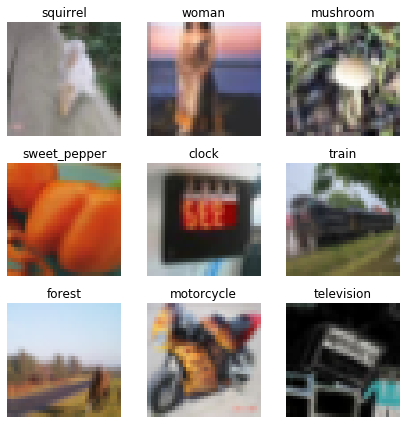

In [ ]:
data.show_batch(3, figsize=(6,6))

## Resnet-56
There is nothing special about this model. For quick tests I like to use this model especially for images with small sizes.

In [ ]:
# Extra Classes for the head of our model
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): 
        return torch.cat([self.mp(x), self.ap(x)], 1)

class Flatten(nn.Module):
    "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
    def __init__(self, full:bool=False):
        super().__init__()
        self.full = full
    def forward(self, x):
        return x.view(-1) if self.full else x.view(x.size(0), -1)

class BasicBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(c_out)
        
        if stride != 1 or c_in != c_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(c_out)
            )
        
    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += shortcut
        return F.relu(out)

### How to implement multi-sample dropout in model
Multi-Sample Dropout is used in the dropout layers that are present in the fully connected layers of your model, that is at the end of the model. So to implement it, you don't have to change your base architecture. Only the head needs to be changed.

For my model the following layers form the head of my model:
```python
head = nn.Sequential(
    AdaptiveConcatPool2d(),
    Flatten(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.25),
    nn.Linear(128, 128, bias=True),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(128),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes, bias=True)
)
```

### Diversity among samples is needed
The key to faster training with multi-sample dropout is the diversity among dropout samples; if there is no diversity, the multi-sample technique gives no gain and simply wastes computation resources. Although dropout is one of the best sources of diversity, the multi-sample technique can be used with other sources of diversity. In the paper they used these two
1. **Horizontal flipping**: This is applied to half of the dropout samples. To implement this, use this code
    ```python
    # Here the suze of out is (num_batches, num_channels, height, width)
    out_flip = torch.flip(out, dims=[3])
    ```
2. **Zero padding at a pooling layer**: This is a tricky one because I don't use max-pool layers at the end of my models. I use Adaptive pooling instead. I don't know if it makes sense to introduce a padding layer before adaptive pooling and then pooling over a random crop. So I skip it for now.

## Code for Multi-Sample Dropout

In [ ]:
class Resnet(nn.Module):
    """
    Forward function can be divided into two parts. First the main backbone of the model
    which is implemented using
    
        out = F.relu(self.bnorm1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
    
    So if you want to add multi-samply dropout to your own models, you don't have to worry
    about changing about your backbone.
    
    Multi-Sample code
    Here I separate the loss computation and the generation of multi-samples. So in the model
    I only create a list and then store my samples in it.
    """
    def __init__(self, num_blocks=[9,9,9], num_classes:int=100, num_samples:int=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group(32, 64, num_blocks[2], stride=2)
        
        # The layers that form my head
        self.pool = AdaptiveConcatPool2d()
        self.flat = Flatten()
        self.bn1 = nn.BatchNorm1d(128)
        self.lin1 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.lin2 = nn.Linear(128, num_classes)
        
        self.num_samples = num_samples

    def make_group(self, c_in, c_out, num_blocks, stride):
        layers = [BasicBlock(c_in, c_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(c_out, c_out, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bnorm1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Multi Sample Dropout
        out_samples = []
        
        # I store the horizontal flip of the feature maps in f_map_flip so as to
        # avoid duplicate computation.
        if self.num_samples > 1:
            f_map_flip = torch.flip(out, dims=[3])
            f_map_flip = self.bn1(self.flat(self.pool(f_map_flip)))
        f_map = self.bn1(self.flat(self.pool(out)))
        
        for i in range(self.num_samples):
            if i%2 == 0:
                # Do not flip the feature map
                out_s = F.dropout(f_map)
            else:
                # Flip the feature map
                out_s = F.dropout(f_map_flip)
            
            out_s = self.lin1(out_s)
            out_s = F.relu(out_s)
            out_s = self.bn2(out_s)
            out_s = F.dropout(out_s)
            out_s = self.lin2(out_s)
            
            out_samples.append(out_s)
        
        return out_samples

## Code for Multi-Sample Dropout Loss Function

In [ ]:
def MultiSampleLoss(input, target, num_samples:int=1):
    total = 0
    for sample in input:
        total += F.cross_entropy(sample, target)
    return total/float(num_samples)

multiSampleLoss = partial(MultiSampleLoss, num_samples=1)

In [ ]:
def accuracy_msd(input, targs):
    for sample in input:
        F.softmax(sample)

## Get baseline without Multi-Sample Dropout

In [ ]:
learn = Learner(data, 
                Resnet(), 
                loss_func=multiSampleLoss,
                wd=1e-4, 
                path='.',
                callback_fns=ShowGraph)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


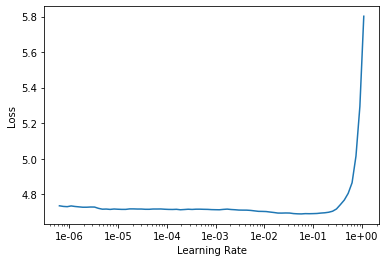

In [ ]:
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,4.374037,4.978892,01:57
1,4.475858,4.792060,01:58
2,4.147432,4.217431,01:52
3,3.693907,3.584197,01:57
4,3.455487,3.389870,01:54


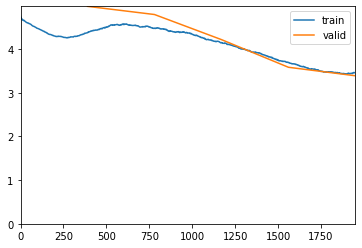

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-1)

epoch,train_loss,valid_loss,time
0,4.240519,4.874904,01:57
1,4.234680,4.252056,01:57
2,3.862857,3.930399,01:57
3,3.410873,3.309648,01:58
4,3.183481,3.136431,01:59


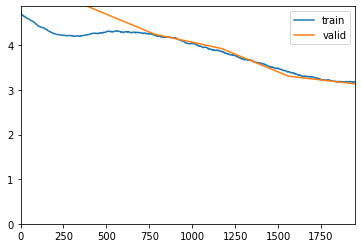

In [ ]:
multiSampleLoss = partial(MultiSampleLoss, num_samples=2)
learn = Learner(data, 
                Resnet(num_samples=2), 
                loss_func=multiSampleLoss,
                wd=1e-4, 
                path='.',
                callback_fns=ShowGraph)
learn.fit_one_cycle(5, max_lr=1e-1)

epoch,train_loss,valid_loss,time
0,4.064822,5.309727,01:59
1,3.934488,4.366735,01:59
2,3.514986,3.451544,01:57
3,3.063990,2.941489,01:57
4,2.839776,2.789385,01:58


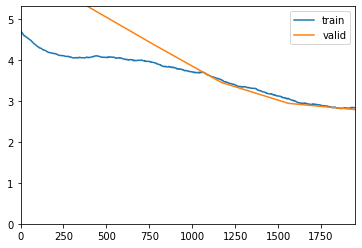

In [ ]:
multiSampleLoss = partial(MultiSampleLoss, num_samples=8)
learn = Learner(data, 
                Resnet(num_samples=8), 
                loss_func=multiSampleLoss,
                wd=1e-4, 
                path='.',
                callback_fns=ShowGraph)
learn.fit_one_cycle(5, max_lr=1e-1)